In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import * 
from keras.utils import to_categorical
import pandas as pd
from google.colab import drive
from tqdm import tqdm


Using TensorFlow backend.


In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class Record():
    def __init__(self,
                 subs_id, month,
                 SMS_in_CNT, SMS_out_CNT,
                 calls_in_CNT, calls_out_CNT,
                 duration_in_min, duration_out_min,
                 data_traffic_MB, sim_LTE,
                 tariff_id, support_3G,
                 support_4G, subs_home_region,
                 charge, recharge,
                 recharge_CNT, life_time,
                 MNP_out
                ):

        self.subs_id = subs_id
        self.date = month
        self.SMS_in_CNT = SMS_in_CNT
        self.SMS_out_CNT = SMS_out_CNT
        self.calls_in_CNT = calls_in_CNT
        self.calls_out_CNT = calls_out_CNT
        self.duration_in_min = duration_in_min
        self.duration_out_min = duration_out_min
        self.data_traffic_MB = data_traffic_MB
        self.sim_LTE = sim_LTE
        self.tariff_id = tariff_id
        self.support_3G = support_3G
        self.support_4G = support_4G
        self.subs_home_region = subs_home_region
        self.charge = charge
        self.recharge = recharge
        self.recharge_CNT = recharge_CNT
        self.life_time = life_time
        self.MNP_out = MNP_out

In [0]:
def get_records(path):
    csv_file = pd.read_csv(path, delimiter=',')
    records = {}
    for c in tqdm(range(len(csv_file))):
        rec = Record(csv_file.at[c, 'SUBS_ID'], csv_file.at[c, 'Month'],
                     csv_file.at[c, 'SMS_IN_CNT'], csv_file.at[c, 'SMS_OUT_CNT'],
                     csv_file.at[c, 'CALLS_IN_CNT'], csv_file.at[c, 'CALLS_OUT_CNT'],
                     csv_file.at[c, 'DURATION_IN_MIN'], csv_file.at[c, 'DURATION_OUT_MIN'],
                     csv_file.at[c, 'DATA_TRAFFIC_MB'], csv_file.at[c, 'SIM_LTE'],
                     csv_file.at[c, 'TARIFF_ID'], csv_file.at[c, 'SUPPORT_3G'],
                     csv_file.at[c, 'SUPPORT_4G'], csv_file.at[c, 'SUBS_HOME_REGION_ID'],
                     csv_file.at[c, 'CHARGE'], csv_file.at[c, 'RECHARGE'],
                     csv_file.at[c, 'RECHARGE_CNT'], csv_file.at[c, 'LIFE_TIME'],
                     csv_file.at[c, 'MNP_OUT'])

        test_rec = []
        if rec.subs_id in records:
            test_rec = records[rec.subs_id]
        test_rec.append(rec)
        records[rec.subs_id] = test_rec
    return records

In [7]:
records = get_records('drive/My Drive/train.csv')

100%|██████████| 299639/299639 [00:34<00:00, 8803.52it/s]


In [8]:
type(records[35243][2].sim_LTE)

numpy.float64

In [0]:
def get_stay_left(ids):
    stay_ids=[]
    left_ids=[]
    fuck = 0
    for id_ in ids:
        for s in records[id_]:
            if np.isnan(s.sim_LTE): 
                #print('fuck')
                fuck+=1
                continue
            
            if s.MNP_out == 0:
                stay_ids.append(id_)
            else: left_ids.append(id_)
    print(fuck)
    return list(set(stay_ids)), list(set(left_ids))

In [10]:
stay_ids, left_ids = get_stay_left([i for i in records])

412


In [11]:
print((len(stay_ids),len(left_ids)))

(96187, 259)


In [0]:
def gen_rand(begin, end, count):
    result = []
    while len(result) < count:
        rand = np.random.randint(begin, end)
        if not result.__contains__(rand):
            result.append(rand)
    return result

In [0]:
stay_ind = gen_rand(0,len(stay_ids),len(left_ids)//10*10)
left_ind = gen_rand(0,len(left_ids),len(left_ids)//10*10)

tli = gen_rand(0,len(left_ids)//10*10, len(left_ids)//10*9)
train_left_ind = [left_ind[i] for i in tli]
valid_left_ind = np.delete(left_ind,tli,0)

tsi = gen_rand(0,len(left_ids)//10*10, len(left_ids)//10*9)
train_stay_ind = [stay_ind[i] for i in tsi]
valid_stay_ind = np.delete(stay_ind,tsi,0)

In [204]:
print((len(train_left_ind),len(train_stay_ind),len(valid_left_ind),len(valid_stay_ind)))

(225, 225, 25, 25)


In [0]:
train_stay_ids = np.array([stay_ids[i] for i in train_stay_ind])
train_left_ids = np.array([left_ids[i] for i in train_left_ind])
train_x_ids = np.concatenate((train_stay_ids, train_left_ids),0)
# train_y = np.concatenate((np.zeros_like(train_stay_ids), np.ones_like(train_left_ids)),0)
# np.random.seed(42)
np.random.shuffle(train_x_ids)
# np.random.shuffle(train_y_ids)

valid_stay_ids = np.array([stay_ids[i] for i in valid_stay_ind])
valid_left_ids = np.array([left_ids[i] for i in valid_left_ind])
test_x_ids = np.concatenate((valid_stay_ids, valid_left_ids),0)
# test_y = np.concatenate((np.zeros_like(valid_stay_ids), np.ones_like(valid_left_ids)),0)
# np.random.seed(42)
np.random.shuffle(test_x_ids)
# np.random.shuffle(test_y_ids)


In [206]:
sh = (train_x_ids.shape[0], test_x_ids.shape[0])
# sh = (train_x_ids.shape[0], train_y.shape[0], test_x_ids.shape[0], test_y.shape[0])
print(sh)

(450, 50)


In [207]:
all_ids = np.concatenate((train_x_ids, test_x_ids),0)
all_ids.shape

(500,)

In [0]:
def prepare(arr):
    def changed(arr): return 1 if len(set(arr)) > 1 else 0
    
    do_mean = [2,3,4,6,8,9,10]
    # do_mean = []
    do_max = [5,11,12,16,17]
    do_changed = [13,18]
    
    new_arr = np.zeros((len(do_mean)+len(do_max)+len(do_changed)))
    label = arr[0].MNP_out
    
    a_vals = []
    
    for s in arr:
        if np.isnan(s.sim_LTE): continue
        attrs = [a for a in dir(s) if not a.startswith('__')]
        vals = [s.__dict__[attr] for attr in attrs]
        # print("vals:", vals)
        a_vals.append(vals)
    
    a_vals = np.array(a_vals)
    #print(a_vals)
    
    ind = 0
    for i1 in do_mean:
        new_arr[ind] = np.mean([float(e) for e in a_vals[:,i1]])
        ind+=1
        
    for i2 in do_max:
        new_arr[ind] = np.max([float(e) for e in a_vals[:,i2]])
        ind+=1
        
    for i3 in do_changed:
        new_arr[ind] = changed([float(e) for e in a_vals[:,i2]])
        ind+=1
    
    #print(new_arr)
    
    return new_arr, label

In [0]:
# data = np.array([prepare(records[i]) for i in all_ids])
raw_data = np.array([prepare(records[i]) for i in all_ids])
data, data_y = np.array([np.array(raw_data[i,0]) for i in range(len(raw_data[:,0]))]), raw_data[:,1]

In [210]:
data.shape, data_y.shape

((500, 14), (500,))

In [211]:
attrs = [a for a in dir(records[1205][0]) if not a.startswith('__')]
[(attrs[i],i) for i in range(len(attrs))]

[('MNP_out', 0),
 ('SMS_in_CNT', 1),
 ('SMS_out_CNT', 2),
 ('calls_in_CNT', 3),
 ('calls_out_CNT', 4),
 ('charge', 5),
 ('data_traffic_MB', 6),
 ('date', 7),
 ('duration_in_min', 8),
 ('duration_out_min', 9),
 ('life_time', 10),
 ('recharge', 11),
 ('recharge_CNT', 12),
 ('sim_LTE', 13),
 ('subs_home_region', 14),
 ('subs_id', 15),
 ('support_3G', 16),
 ('support_4G', 17),
 ('tariff_id', 18)]

In [0]:
def std_data(data):
    def std_arr(arr):
        arr = arr - arr.mean()
        arr = arr / arr.std()
        return arr

    t_data = data.transpose()
    std_data = np.zeros_like(t_data)
    ind = 0
    for col in t_data:
        std_data[ind,:] = std_arr(col)[:]
        ind+=1
    return std_data.transpose()

In [0]:
std_data = std_data(data)

In [214]:
std_data.shape

(500, 14)

In [0]:
train_x, test_x = std_data[0:sh[0],:], std_data[sh[0]:,:]
train_y, test_y = data_y[0:sh[0]], data_y[sh[0]:]

In [0]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
# train_y = train_y.reshape(-1,1)
# test_y = test_y.reshape(-1,1)

In [217]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((450, 14), (50, 14), (450, 2), (50, 2))

In [0]:
def model():
    model = Sequential()
    model.add(Dense(train_x.shape[1], input_dim=train_x.shape[1], activation='sigmoid'))
    model.add(Dense(2, activation = 'softmax'))
    return model

model = model()

In [0]:
model.compile(optimizer = Adam(lr=0.01), loss = 'categorical_crossentropy', metrics = ['acc'])

In [269]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 30        
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________


In [0]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, min_delta=0.004, patience=15, min_lr=0.005, verbose=1)

In [0]:
early_stop = EarlyStopping(monitor='acc', min_delta=0.0085, patience=40, verbose=1)

In [272]:
history1 = model.fit(train_x, train_y, batch_size = 45, epochs=2000, shuffle = True, verbose = 1, validation_data=(test_x,test_y), callbacks=[reduce_lr, early_stop])

Train on 450 samples, validate on 50 samples
Epoch 1/2000
450/450 [==============================] - 2s 4ms/step - loss: 0.7137 - acc: 0.4689 - val_loss: 0.7179 - val_acc: 0.6000
Epoch 2/2000
450/450 [==============================] - 0s 194us/step - loss: 0.6601 - acc: 0.6267 - val_loss: 0.7209 - val_acc: 0.5400
Epoch 3/2000
450/450 [==============================] - 0s 131us/step - loss: 0.6541 - acc: 0.6222 - val_loss: 0.7181 - val_acc: 0.5400
Epoch 4/2000
450/450 [==============================] - 0s 116us/step - loss: 0.6503 - acc: 0.6267 - val_loss: 0.7038 - val_acc: 0.6400
Epoch 5/2000
450/450 [==============================] - 0s 117us/step - loss: 0.6487 - acc: 0.6356 - val_loss: 0.6969 - val_acc: 0.6200
Epoch 6/2000
450/450 [==============================] - 0s 134us/step - loss: 0.6465 - acc: 0.6289 - val_loss: 0.6969 - val_acc: 0.6400
Epoch 7/2000
450/450 [==============================] - 0s 135us/step - loss: 0.6440 - acc: 0.6400 - val_loss: 0.6912 - val_acc: 0.6400
Epoch

In [273]:
model.evaluate(test_x, test_y, batch_size=1, verbose=1)

50/50 [==============================] - 0s 3ms/step


[0.714082019738853, 0.72]

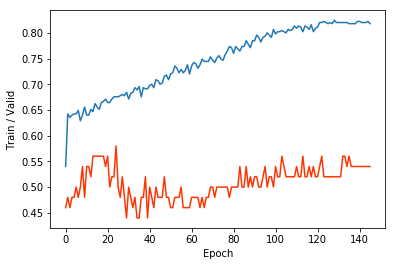

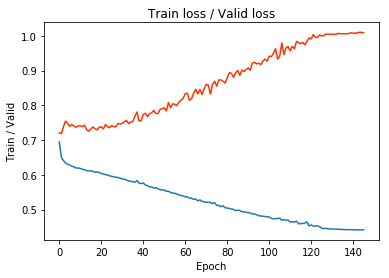

In [43]:
# Рисуем график ответов
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'],color = (1,0.2,0,1))
# plt.title('Train accuracy / Valid accuracy')
plt.ylabel('Train / Valid')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Рисуем график ошибок
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'], color = (1,0.2,0,1))
plt.title('Train loss / Valid loss')
plt.ylabel('Train / Valid')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
#model.save('drive/My Drive/model70.h5') 

In [275]:
test_rec = get_records('drive/My Drive/test.csv')

100%|██████████| 299220/299220 [00:34<00:00, 8642.98it/s]


In [0]:
test_data = []
ids = np.array(list(set([k for k in test_rec])))
for us in ids:
    test_data.append(prepare(test_rec[us])[0])
    
test_data = np.array(test_data)
# test_data = test_data.reshape((len(ids), 14))

In [282]:
len(ids)

96656

In [283]:
test_data.shape


(96656, 14)

In [0]:
res = model.predict(test_data)

In [285]:
res.shape

(96656, 2)

In [0]:
dic = {}
for id_ in range(len(ids)):
    dic[int(ids[id_])] = (int(1 - np.argmax(res[id_,:])), float(np.max(res[id_,:])))

In [0]:
import random
import xlwt


In [0]:
def write_to_excel(dictionary):
    wb = xlwt.Workbook('hackaton2.xls')
    number = 1
    ws = wb.add_sheet('Result' + str(number))
    ws.write(0, 0, "SUBS_ID")
    ws.write(0, 1, "MNP_OUT")
    ws.write(0, 2, "Probability")
    row_count = 1
    for key in dictionary.keys():
        if row_count > 65535:
            number += 1
            ws = wb.add_sheet('Result' + str(number))
            ws.write(0, 0, "SUBS_ID")
            ws.write(0, 1, "MNP_OUT")
            ws.write(0, 2, "Probability")
            row_count = 1
        key_cell = key
        mnp_out_cell, probability_cell = dictionary[key]
        ws.write(row_count, 0, key_cell)
        ws.write(row_count, 1, mnp_out_cell)
        ws.write(row_count, 2, probability_cell)
        row_count += 1
    wb.save('drive/My Drive/hackaton2.xls')

In [0]:

write_to_excel(dic)